# Load Data

Здесь мы загружаем необходимые данные с google disk, после чего удаляем поврежденные картинки

In [ ]:
!rm catdogs.zip
!curl -o catdogs.zip -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1e9oZ8j8pEKTt004Ez4fsVxyUJFy6tZ9q'
!unzip -o catdogs.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImag

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import imghdr

In [ ]:
data_dir = 'PetImages'

In [ ]:
print(os.listdir(data_dir))

['Dog', 'Cat']


In [ ]:
# to_numpy array
img = cv2.imread(os.path.join(data_dir,'Cat','0.jpg'))
img.shape

(375, 500, 3)

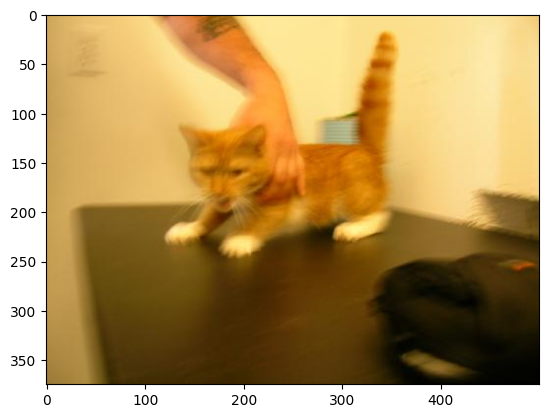

In [ ]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
# find and delete corrupted images

import os
import tensorflow as tf

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Using PyTorch

Создадим CNN для определения класса изображений между кошками и собаками. Здесь мы будем использовать Fine-tuning для достижения высокой точности.

In [ ]:
# import lib

import os, glob, shutil
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchvision.models import vgg16
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with RandomHorizontalFlip and RandomRotation

data_dir = 'PetImages'
dataset = ImageFolder(data_dir)
train_data, test_data, train_label, test_label = train_test_split(
    dataset.imgs, dataset.targets,
    test_size=0.1, random_state=42
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 32

class DogVsCatDataset(Dataset):
    def __init__(self, dataset, transform=None, IMAGE_SIZE=32):
        self.dataset = self.is_channel_RGB(dataset)
        self.transform = transform

    def __len__(self):
        '''
        get the length of the dataset
        '''
        return len(self.dataset)

    def __getitem__(self, idx):
        '''
        get the image and label, apply the transformation/augmentation
        '''
        image = Image.open(self.dataset[idx][0])
        label = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, label

    def collate_fn(self, batch):
        '''
        preprocess images, labels before loading to training/validating
        '''
        imgs, labels = [], []
        for im, label in batch:

            im = self.preprocess_image(im)
            imgs.append(im)

            labels.append(float(label))

        labels = torch.tensor(labels).to(device).float()
        imgs = torch.cat(imgs).to(device)
        imgs = imgs.view(-1,3,IMAGE_SIZE,IMAGE_SIZE)

        return imgs, labels

    def is_channel_RGB(self, dataset):
        '''
        Include only the images that has RGB channels in it. Exclude Rest.
        '''
        dataset_RGB = []
        for idx in range(len(dataset)):
            if (Image.open(dataset[idx][0]).getbands() == ("R", "G", "B")):
                dataset_RGB.append(dataset[idx])
        return dataset_RGB


# train transform for train data (data_augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.Resize((32,32)),
    transforms.ToTensor()
])


# val transform for test data
val_transform = transforms.Compose([
        transforms.Resize((32,32)),
    transforms.ToTensor()
    ])

train_dataset = DogVsCatDataset(train_data, transform=train_transform, IMAGE_SIZE=IMAGE_SIZE)
test_dataset = DogVsCatDataset(test_data, transform=val_transform, IMAGE_SIZE=IMAGE_SIZE)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 32, number of channels: 3, pixel sizes: 32x32)

(32, 3, 32, 32)

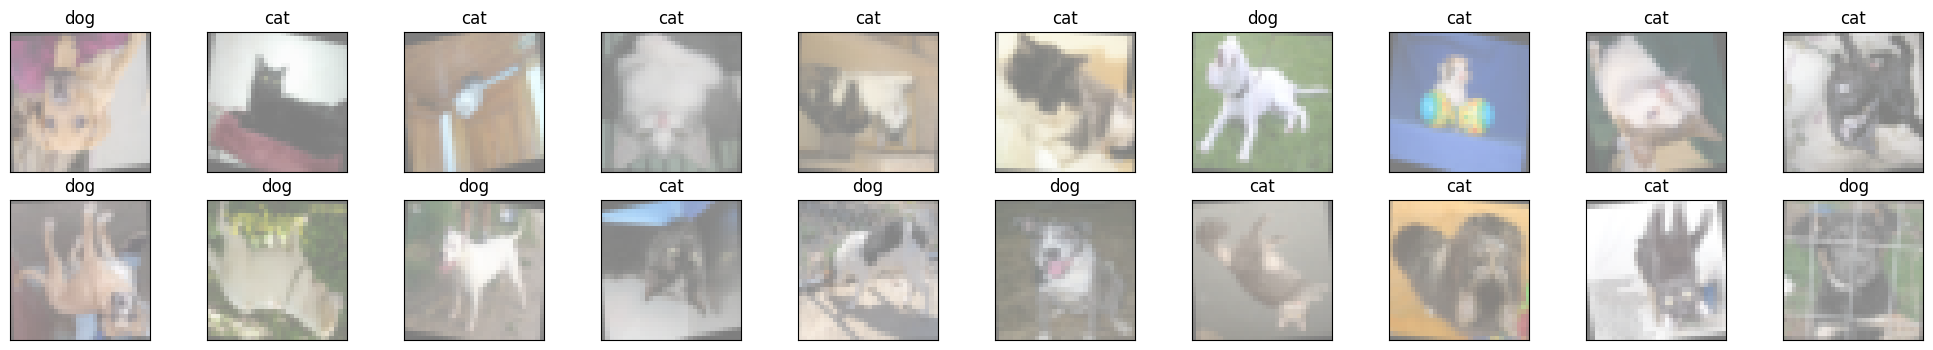

In [ ]:
# plot the images in the batch, along with the corresponding labels
classes = ['cat','dog']
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
print(f'Num training images: {len(train_loader.dataset)}')
print(f'Num validation images: {len(valid_loader.dataset)}')
print(f'Num test images: {len(test_loader.dataset)}')

Num training images: 21061
Num validation images: 21061
Num test images: 2341


In [ ]:
# Creating two function for testing and training

def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
# Download models pretrained on ImageNet with PyTorch Hub

model_resnet18 = torch.hub.load('pytorch/vision', 'resnet18', weights='ResNet18_Weights.IMAGENET1K_V1')
model_resnet34 = torch.hub.load('pytorch/vision', 'resnet34', weights='ResNet34_Weights.IMAGENET1K_V1')

for name, param in model_resnet18.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

for name, param in model_resnet34.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

# replace the classifier so we can make predictions on custom dataset
# rather than the 1,000 classes from ImageNet the model was trained on
num_classes = 2

model_resnet18.fc = nn.Sequential(nn.Linear(model_resnet18.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))


model_resnet18.to(device)
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
train(model_resnet18, optimizer, torch.nn.CrossEntropyLoss(), train_loader, valid_loader, epochs=10, device=device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Epoch: 0, Training Loss: 0.5235, Validation Loss: 0.1184, accuracy = 0.6873
Epoch: 1, Training Loss: 0.4726, Validation Loss: 0.1100, accuracy = 0.7236
Epoch: 2, Training Loss: 0.4458, Validation Loss: 0.1066, accuracy = 0.7339
Epoch: 3, Training Loss: 0.4348, Validation Loss: 0.1034, accuracy = 0.7462
Epoch: 4, Training Loss: 0.4250, Validation Loss: 0.1038, accuracy = 0.7517
Epoch: 5, Training Loss: 0.4211, Validation Loss: 0.1000, accuracy = 0.7547
Epoch: 6, Training Loss: 0.4127, Validation Loss: 0.0990, accuracy = 0.7600
Epoch: 7, Training Loss: 0.4054, Validation Loss: 0.0976, accuracy = 0.7678
Epoch: 8, Training Loss: 0.4023, Validation Loss: 0.0987, accuracy = 0.7647
Epoch: 9, Training Loss: 0.3994, Validation Loss: 0.0974, accuracy = 0.7726


In [ ]:
test_model(model_resnet18)

correct: 1801  total: 2341
accuracy = 0.769329


In [ ]:
# plot confusion matrix and classification report for each model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

def matrix(model):
    num_classes = 2

    predlist = torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
    predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            model.eval()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
    predlist = predlist.numpy()
    lbllist = lbllist.numpy()
    predlistauc = predlistauc.numpy()

    # Confusion matrix, classification report and AUC
    conf_mat=confusion_matrix(lbllist, predlist)
    target_names = ['cat','dog']
    ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
    print(classification_report(lbllist, predlist, target_names=target_names))
    lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
    every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]),
                                              predlistauc, multi_class='ovr', average=None)
    for i, every in enumerate(target_names):
        print(f'AUC of class {every} = {every_auc[i]}')

              precision    recall  f1-score   support

         cat       0.74      0.83      0.78      1182
         dog       0.80      0.71      0.75      1159

    accuracy                           0.77      2341
   macro avg       0.77      0.77      0.77      2341
weighted avg       0.77      0.77      0.77      2341

AUC of class cat = 0.8521991506184952
AUC of class dog = 0.8521991506184952


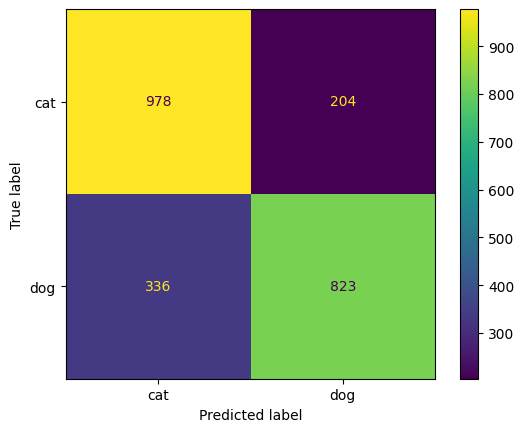

In [ ]:
matrix(model_resnet18)

In [ ]:
model_resnet34.to(device)
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001)
train(model_resnet34, optimizer, torch.nn.CrossEntropyLoss(), train_loader, valid_loader, epochs=10, device=device)

Epoch: 0, Training Loss: 0.5167, Validation Loss: 0.1178, accuracy = 0.6914
Epoch: 1, Training Loss: 0.4639, Validation Loss: 0.1091, accuracy = 0.7272
Epoch: 2, Training Loss: 0.4369, Validation Loss: 0.1081, accuracy = 0.7346
Epoch: 3, Training Loss: 0.4202, Validation Loss: 0.1016, accuracy = 0.7581
Epoch: 4, Training Loss: 0.4066, Validation Loss: 0.0991, accuracy = 0.7654
Epoch: 5, Training Loss: 0.4002, Validation Loss: 0.0968, accuracy = 0.7671
Epoch: 6, Training Loss: 0.3939, Validation Loss: 0.0972, accuracy = 0.7647
Epoch: 7, Training Loss: 0.3858, Validation Loss: 0.0942, accuracy = 0.7764
Epoch: 8, Training Loss: 0.3772, Validation Loss: 0.0928, accuracy = 0.7828
Epoch: 9, Training Loss: 0.3738, Validation Loss: 0.0915, accuracy = 0.7842


In [ ]:
test_model(model_resnet34)

correct: 1836  total: 2341
accuracy = 0.784280


              precision    recall  f1-score   support

         cat       0.79      0.78      0.79      1182
         dog       0.78      0.79      0.78      1159

    accuracy                           0.78      2341
   macro avg       0.78      0.78      0.78      2341
weighted avg       0.78      0.78      0.78      2341

AUC of class cat = 0.867442176215274
AUC of class dog = 0.867442176215274


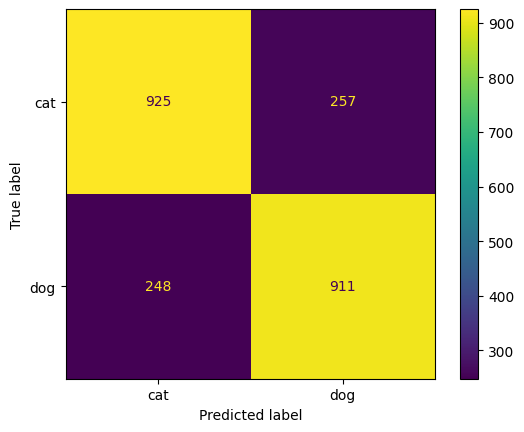

In [ ]:
matrix(model_resnet34)

In [ ]:
import os

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_prediction(model, filename):
    labels, _ = find_classes('PetImages')
    img = Image.open(filename)
    img = val_transform(img)
    img = img.unsqueeze(0)
    prediction = model(img.to(device))
    prediction = prediction.argmax()
    print(labels[prediction])

make_prediction(model_resnet34, 'PetImages/Dog/1.jpg')
make_prediction(model_resnet34, 'PetImages/Cat/0.jpg')

Cat
Cat


In [ ]:
# Test Accuracy Function

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
criterion = torch.nn.CrossEntropyLoss()
model_resnet34.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if device:
        data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_resnet34(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(5):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.456918

Test Accuracy of   cat: 74% (151/203)
Test Accuracy of   dog: 77% (130/167)

Test Accuracy (Overall): 75% (281/370)


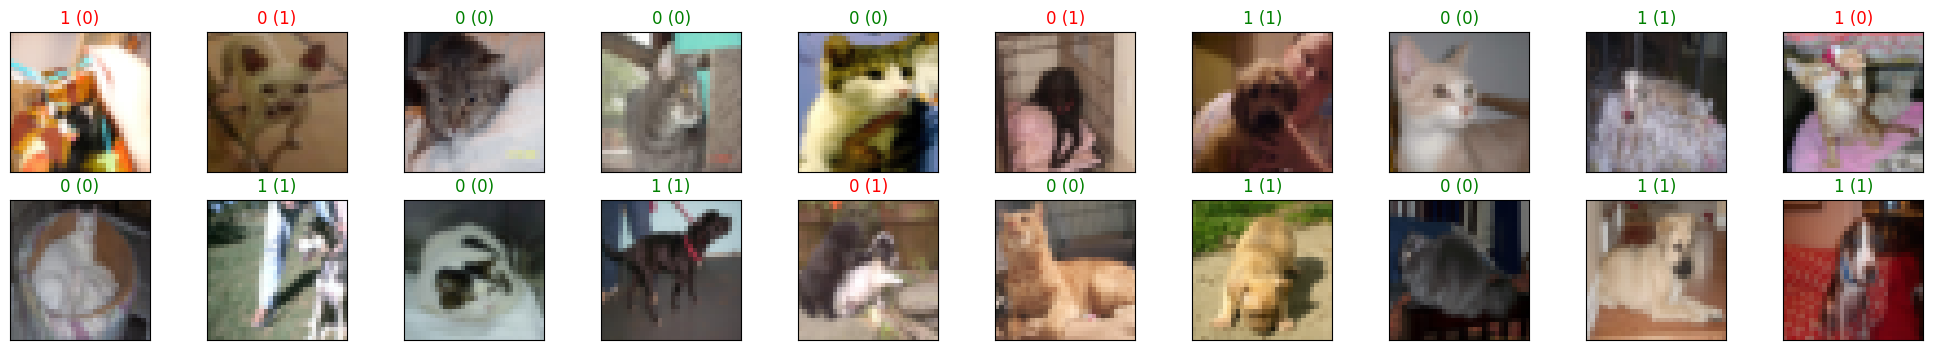

In [ ]:
# plot images and its prediction classes


dataiter = iter(test_loader)
images, labels = next(dataiter)
prediction = model_resnet34(images.to(device))
_,prediction = torch.max(prediction, 1)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(np.squeeze(images[idx]),(1,2,0)), cmap='gray')
    ax.set_title("{} ({})".format(str(prediction[idx].item()), str(labels[idx].item())),
                 color=("green" if prediction[idx]==labels[idx] else "red"))

Dog


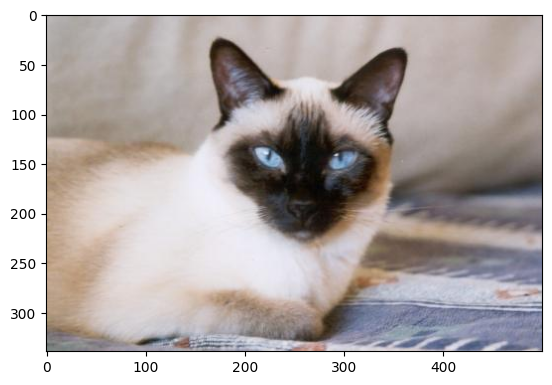

In [ ]:
# plot some image

from keras.preprocessing import image

#Input image
img = cv2.imread(os.path.join(data_dir,'Cat','10709.jpg'))

#For show image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# Result array
result = make_prediction(model_resnet34, 'PetImages/Cat/10709.jpg')
plt.title(result)
plt.show()


In [ ]:
# save models

torch.save(model_resnet34.state_dict(), "./model_resnet34.pth")
resnet34 = torch.hub.load('pytorch/vision', 'resnet34')
resnet34.fc = nn.Sequential(nn.Linear(resnet34.fc.in_features,512),nn.ReLU(), nn.Dropout(), nn.Linear(512, num_classes))
resnet34.load_state_dict(torch.load('./model_resnet34.pth'))
resnet34.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Using cache found in /root/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Test against the average of each prediction from the two models

models_ensemble = [resnet34.to(device)]
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        predictions = [i(images).data for i in models_ensemble]
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
        _, predicted = torch.max(avg_predictions, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('accuracy = {:f}'.format(correct / total))
print('correct: {:d}  total: {:d}'.format(correct, total))

accuracy = 0.784280
correct: 1836  total: 2341
